In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm

pd.set_option("display.max_column", 999)

## Data Collection and Cleaning

In [86]:
data_path = '../input/march-machine-learning-mania-2025/'

In [87]:
seeds_df = pd.concat(
    [
        pd.read_csv(data_path + "MNCAATourneySeeds.csv").assign(Sex = "M"),
        pd.read_csv(data_path + "WNCAATourneySeeds.csv").assign(Sex = "W")
    ], ignore_index = True)

reg_season_df = pd.concat(
    [
        pd.read_csv(data_path + "MRegularSeasonDetailedResults.csv").assign(Sex = "M"),
        pd.read_csv(data_path + "WRegularSeasonDetailedResults.csv").assign(Sex = "W")
    ], ignore_index = True)

tourney_df = pd.concat(
    [
        pd.read_csv(data_path + "MNCAATourneyDetailedResults.csv").assign(Sex = "M"),
        pd.read_csv(data_path + "WNCAATourneyDetailedResults.csv").assign(Sex = "W")
    ], ignore_index = True)

In [88]:
print("seeds_df Dimensions:", seeds_df.shape)
print("reg_season_df Dimensions:", reg_season_df.shape)
print("tourney_df Dimensions:", tourney_df.shape)

seeds_df Dimensions: (4370, 4)
reg_season_df Dimensions: (200590, 35)
tourney_df Dimensions: (2276, 35)


In [89]:
print(reg_season_df.columns)
print(tourney_df.columns)

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'Sex'],
      dtype='object')
Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'Sex'],
      dtype='object')


In [90]:
reg_season_T2 = reg_season_df[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'Sex']]

In [91]:
reg_season_T2.loc[reg_season_df['WLoc'] == 'H', 'WLoc'] = 'A'
reg_season_T2.loc[reg_season_df['WLoc'] == 'A', 'WLoc'] = 'H'
reg_season_df.rename(columns={"WLoc": "location"}, inplace=True)
reg_season_T2.rename(columns={"WLoc": "location"}, inplace=True)

In [92]:
print(reg_season_T2.shape)
print(reg_season_df.shape)

(200590, 35)
(200590, 35)


In [93]:
reg_season_df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(reg_season_df.columns)]
reg_season_T2.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(reg_season_T2.columns)]

In [94]:
reg_season_df.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,Sex
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,M
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,M
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,M
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,M
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,M


In [95]:
reg_season_T2.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,Sex
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22,M
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18,M
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25,M
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18,M
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20,M


In [96]:
reg_season_team_df = pd.concat(
    [reg_season_df, reg_season_T2]).sort_index().reset_index(drop = True)

# Adding Score Differential
reg_season_team_df["ScoreDiff"] = (
    reg_season_team_df["T1_Score"] - reg_season_team_df["T2_Score"]
)

reg_season_team_df['location'] = reg_season_team_df['location'].map(
    {'N': 0, 'H': 1, 'A': -1}).astype(int)

# Checking the dataset
reg_season_team_df.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,Sex,ScoreDiff
0,2003,10,1104,68,1328,62,0,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,M,6
1,2003,10,1328,62,1104,68,0,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22,M,-6
2,2003,10,1272,70,1393,63,0,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,M,7
3,2003,10,1393,63,1272,70,0,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18,M,-7
4,2003,11,1266,73,1437,61,0,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,M,12


Now doing the same with the Tourney Data

In [97]:
tourney_T2 = tourney_df[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'Sex']]

In [98]:
tourney_T2.loc[tourney_df['WLoc'] == 'H', 'WLoc'] = 'A'
tourney_T2.loc[tourney_df['WLoc'] == 'A', 'WLoc'] = 'H'
tourney_df.rename(columns={"WLoc": "location"}, inplace=True)
tourney_T2.rename(columns={"WLoc": "location"}, inplace=True)

In [99]:
tourney_df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(tourney_df.columns)]
tourney_T2.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(tourney_T2.columns)]

In [100]:
tourney_team_df = pd.concat(
    [tourney_df, tourney_T2]).sort_index().reset_index(drop = True)

# Adding Score Differential
tourney_team_df["ScoreDiff"] = (
    tourney_team_df["T1_Score"] - tourney_team_df["T2_Score"]
)

tourney_team_df['location'] = tourney_team_df['location'].map(
    {'N': 0, 'H': 1, 'A': -1}).astype(int)

# Checking the dataset
tourney_team_df.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,Sex,ScoreDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,M,8
1,2003,134,1411,84,1421,92,0,1,29,67,12,31,14,31,17,28,16,15,5,0,22,32,69,11,29,17,26,14,30,17,12,5,3,22,M,-8
2,2003,136,1436,51,1112,80,0,0,20,64,4,16,7,7,8,26,12,17,10,3,15,31,66,7,23,11,14,11,36,22,16,10,7,8,M,-29
3,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,M,29
4,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,M,13


## Feature Engineering

In [101]:
# Aggregating the data
agg_team_stats = reg_season_team_df.groupby(["Season", "T1_TeamID", "Sex"]).agg(
    AvgScoreDiff = ("ScoreDiff", "mean"),
    T1_Score_total = ("T1_Score", "sum"),  
    T2_Score_total = ("T2_Score", "sum"),
    T1_FGA_total = ("T1_FGA", "sum"),
    T1_FTA_total = ("T1_FTA", "sum"),
    T2_FGA_total = ("T2_FGA", "sum"),
    T2_FTA_total = ("T2_FTA", "sum"), 
    T1_OR_total = ("T1_OR", "sum"),
    T1_DR_total = ("T1_DR", "sum"),
    T2_OR_total = ("T2_OR", "sum"),
    T2_DR_total = ("T2_DR", "sum"),
    T1_Ast_total = ("T1_Ast", "sum"),
    T2_Ast_total = ("T2_Ast", "sum"),
    T1_TO_total = ("T1_TO", "sum"),
    T2_TO_total = ("T2_TO", "sum"),
    T1_Stl_total = ("T1_Stl", "sum"),
    T2_Stl_total = ("T2_Stl", "sum"),
    T1_Blk_total = ("T1_Blk", "sum"),
    T2_Blk_total = ("T2_Blk", "sum"),
    T1_PF_total = ("T1_PF", "sum"),
    T2_PF_total = ("T2_PF", "sum"),
    T1_FGM_total = ("T1_FGM", "sum"),
    T1_FGM3_total = ("T1_FGM3", "sum"),
    T2_FGM_total = ("T2_FGM", "sum"),
    T2_FGM3_total = ("T2_FGM3", "sum")
).reset_index()
agg_team_stats

,Season,T1_TeamID,Sex,AvgScoreDiff,T1_Score_total,T2_Score_total,T1_FGA_total,T1_FTA_total,T2_FGA_total,T2_FTA_total,T1_OR_total,T1_DR_total,T2_OR_total,T2_DR_total,T1_Ast_total,T2_Ast_total,T1_TO_total,T2_TO_total,T1_Stl_total,T2_Stl_total,T1_Blk_total,T2_Blk_total,T1_PF_total,T2_PF_total,T1_FGM_total,T1_FGM3_total,T2_FGM_total,T2_FGM3_total
0,2003,1102,M,0.250000,1603,1596,1114,479,1188,539,117,471,269,564,364,256,320,363,167,152,50,44,525,514,536,219,540,133
1,2003,1103,M,0.629630,2127,2110,1508,698,1539,598,264,538,325,595,411,418,341,414,196,173,63,77,536,606,733,147,750,180
2,2003,1104,M,4.285714,1940,1820,1601,586,1554,480,380,670,305,634,339,327,372,388,185,155,106,89,505,539,673,178,651,178
3,2003,1105,M,-4.884615,1866,1993,1602,568,1533,637,351,601,343,686,378,411,485,489,242,244,54,109,526,496,634,197,702,163
4,2003,1106,M,-0.142857,1781,1785,1548,461,1495,615,344,668,317,626,327,330,477,422,234,246,88,89,509,452,656,171,608,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13578,2025,3476,W,-2.645161,1979,2061,1784,338,1841,446,283,718,282,662,508,395,496,399,140,281,81,92,453,484,742,223,767,202
13579,2025,3477,W,-11.296296,1644,1949,1611,332,1709,491,188,622,307,742,353,390,412,353,169,221,86,82,467,351,607,191,727,159
13580,2025,3478,W,-15.096774,1670,2138,1593,465,1861,339,226,668,305,734,302,514,491,368,163,242,54,79,425,486,562,196,812,265
13581,2025,3479,W,-7.708333,1507,1692,1267,438,1410,441,127,537,201,585,251,297,427,368,136,213,29,57,449,472,516,160,633,115


If we can transform our metrics on a per-posession basis, we can level the playing field between teams with different playstyles.

In [102]:
agg_team_stats["T1_Possessions"] = (agg_team_stats["T1_FGA_total"] + 0.44 * agg_team_stats["T1_FTA_total"] + agg_team_stats["T1_TO_total"] - agg_team_stats["T1_OR_total"])
agg_team_stats["T2_Possessions"] = (agg_team_stats["T2_FGA_total"] + 0.44 * agg_team_stats["T2_FTA_total"] + agg_team_stats["T2_TO_total"] - agg_team_stats["T2_OR_total"])

If we use stats per 100 possessions, it makes it easier to compare teams by normalizing for variables such as game tempo and overtime. It helps to smooth out any shifts in a team's performance throughout the season, so we can get a better, more consistent picture of how they’re actually playing. With these calculations it is possible for the denominator to equal zero so we need to figure out a solution for that. I chose different methods depending on the statistic.

In [103]:
# Points per 100 possessions
agg_team_stats["T1_Pts_p100"] = np.where(
    agg_team_stats["T1_Possessions"] > 0,
    (agg_team_stats["T1_Score_total"] / agg_team_stats["T1_Possessions"]) * 100,
    np.nan
)
agg_team_stats["T2_Pts_p100"] = np.where(
    agg_team_stats["T2_Possessions"] > 0,
    (agg_team_stats["T2_Score_total"] / agg_team_stats["T2_Possessions"]) * 100,
    np.nan
)

# Assists per 100 possessions
agg_team_stats["T1_Ast_p100"] = np.where(
    agg_team_stats["T1_Possessions"] > 0,
    (agg_team_stats["T1_Ast_total"] / agg_team_stats["T1_Possessions"]) * 100,
    np.nan
)
agg_team_stats["T2_Ast_p100"] = np.where(
    agg_team_stats["T2_Possessions"] > 0,
    (agg_team_stats["T2_Ast_total"] / agg_team_stats["T2_Possessions"]) * 100,
    np.nan
)

# Rebounds per 100 possessions
agg_team_stats["T1_Reb_p100"] = np.where(
    agg_team_stats["T1_Possessions"] > 0,
    ((agg_team_stats["T1_OR_total"] + agg_team_stats["T1_DR_total"]) / agg_team_stats["T1_Possessions"]) * 100,
    np.nan
)
agg_team_stats["T2_Reb_p100"] = np.where(
    agg_team_stats["T2_Possessions"] > 0,
    ((agg_team_stats["T2_OR_total"] + agg_team_stats["T2_DR_total"]) / agg_team_stats["T2_Possessions"]) * 100,
    np.nan
)

# Turnovers per 100 possessions
agg_team_stats["T1_TO_p100"] = np.where(
    agg_team_stats["T1_Possessions"] > 0,
    (agg_team_stats["T1_TO_total"] / agg_team_stats["T1_Possessions"]) * 100,
    np.nan
)
agg_team_stats["T2_TO_p100"] = np.where(
    agg_team_stats["T2_Possessions"] > 0,
    (agg_team_stats["T2_TO_total"] / agg_team_stats["T2_Possessions"]) * 100,
    np.nan
)

# Steals per 100 possessions
agg_team_stats["T1_Stl_p100"] = np.where(
    agg_team_stats["T1_Possessions"] > 0,
    (agg_team_stats["T1_Stl_total"] / agg_team_stats["T1_Possessions"]) * 100,
    np.nan
)
agg_team_stats["T2_Stl_p100"] = np.where(
    agg_team_stats["T2_Possessions"] > 0,
    (agg_team_stats["T2_Stl_total"] / agg_team_stats["T2_Possessions"]) * 100,
    np.nan
)

# Blocks per 100 possessions
agg_team_stats["T1_Blk_p100"] = np.where(
    agg_team_stats["T1_Possessions"] > 0,
    (agg_team_stats["T1_Blk_total"] / agg_team_stats["T1_Possessions"]) * 100,
    np.nan
)
agg_team_stats["T2_Blk_p100"] = np.where(
    agg_team_stats["T2_Possessions"] > 0,
    (agg_team_stats["T2_Blk_total"] / agg_team_stats["T2_Possessions"]) * 100,
    np.nan
)

# Personal Fouls per 100 possessions
agg_team_stats["T1_PF_p100"] = np.where(
    agg_team_stats["T1_Possessions"] > 0,
    (agg_team_stats["T1_PF_total"] / agg_team_stats["T1_Possessions"]) * 100,
    np.nan
)
agg_team_stats["T2_PF_p100"] = np.where(
    agg_team_stats["T2_Possessions"] > 0,
    (agg_team_stats["T2_PF_total"] / agg_team_stats["T2_Possessions"]) * 100,
    np.nan
)

# Net Rating per 100 possessoions
agg_team_stats["Net_Rating_p100"] = agg_team_stats["T1_Pts_p100"] - agg_team_stats["T2_Pts_p100"]

### Adding other features that could possibly assist

In [104]:
# True Shooting Percentage
agg_team_stats["T1_TS_Pct"] = np.where(
    (agg_team_stats["T1_FGA_total"] + 0.44 * agg_team_stats["T1_FTA_total"]) > 0,
    agg_team_stats["T1_Score_total"] / (2 * (agg_team_stats["T1_FGA_total"] + 0.44 * agg_team_stats["T1_FTA_total"])),
    0
)

agg_team_stats["T2_TS_Pct"] = np.where(
    (agg_team_stats["T2_FGA_total"] + 0.44 * agg_team_stats["T2_FTA_total"]) > 0,
    agg_team_stats["T2_Score_total"] / (2 * (agg_team_stats["T2_FGA_total"] + 0.44 * agg_team_stats["T2_FTA_total"])),
    0
)

# Effective FG Percentage
agg_team_stats["T1_eFG_Pct"] = np.where(
    agg_team_stats["T1_FGA_total"] > 0,
    (agg_team_stats["T1_FGM_total"] + 0.5 * agg_team_stats["T1_FGM3_total"]) / agg_team_stats["T1_FGA_total"],
    0
)
agg_team_stats["T2_eFG_Pct"] = np.where(
    agg_team_stats["T2_FGA_total"] > 0,
    (agg_team_stats["T2_FGM_total"] + 0.5 * agg_team_stats["T2_FGM3_total"]) / agg_team_stats["T2_FGA_total"],
    0
)

# Rebound Percentage
agg_team_stats["T1_Reb_Pct"] = np.where(
    (agg_team_stats["T1_OR_total"] + agg_team_stats["T1_DR_total"] + agg_team_stats["T2_OR_total"] + agg_team_stats["T2_DR_total"]) > 0,
    (agg_team_stats["T1_OR_total"] + agg_team_stats["T1_DR_total"]) / 
    (agg_team_stats["T1_OR_total"] + agg_team_stats["T1_DR_total"] + agg_team_stats["T2_OR_total"] + agg_team_stats["T2_DR_total"]),
    0
)

agg_team_stats["T1_Off_Reb_Pct"] = np.where(
    (agg_team_stats["T1_OR_total"] + agg_team_stats["T2_DR_total"]) > 0,
    agg_team_stats["T1_OR_total"] / (agg_team_stats["T1_OR_total"] + agg_team_stats["T2_DR_total"]),
    0
)

agg_team_stats["T1_Def_Reb_Pct"] = np.where(
    (agg_team_stats["T1_DR_total"] + agg_team_stats["T2_OR_total"]) > 0,
    agg_team_stats["T1_DR_total"] / (agg_team_stats["T1_DR_total"] + agg_team_stats["T2_OR_total"]),
    0
)

# Assist to Turnover Ratio
agg_team_stats["T1_AST_TO_Ratio"] = agg_team_stats["T1_Ast_total"] / np.where(agg_team_stats["T1_TO_total"] == 0, 1, agg_team_stats["T1_TO_total"])
agg_team_stats["T2_AST_TO_Ratio"] = agg_team_stats["T2_Ast_total"] / np.where(agg_team_stats["T2_TO_total"] == 0, 1, agg_team_stats["T2_TO_total"])

In [105]:
agg_team_stats.columns

Index(['Season', 'T1_TeamID', 'Sex', 'AvgScoreDiff', 'T1_Score_total',
       'T2_Score_total', 'T1_FGA_total', 'T1_FTA_total', 'T2_FGA_total',
       'T2_FTA_total', 'T1_OR_total', 'T1_DR_total', 'T2_OR_total',
       'T2_DR_total', 'T1_Ast_total', 'T2_Ast_total', 'T1_TO_total',
       'T2_TO_total', 'T1_Stl_total', 'T2_Stl_total', 'T1_Blk_total',
       'T2_Blk_total', 'T1_PF_total', 'T2_PF_total', 'T1_FGM_total',
       'T1_FGM3_total', 'T2_FGM_total', 'T2_FGM3_total', 'T1_Possessions',
       'T2_Possessions', 'T1_Pts_p100', 'T2_Pts_p100', 'T1_Ast_p100',
       'T2_Ast_p100', 'T1_Reb_p100', 'T2_Reb_p100', 'T1_TO_p100', 'T2_TO_p100',
       'T1_Stl_p100', 'T2_Stl_p100', 'T1_Blk_p100', 'T2_Blk_p100',
       'T1_PF_p100', 'T2_PF_p100', 'Net_Rating_p100', 'T1_TS_Pct', 'T2_TS_Pct',
       'T1_eFG_Pct', 'T2_eFG_Pct', 'T1_Reb_Pct', 'T1_Off_Reb_Pct',
       'T1_Def_Reb_Pct', 'T1_AST_TO_Ratio', 'T2_AST_TO_Ratio'],
      dtype='object')

In [106]:
# Keeping the relevant statistics
agg_team_stats = agg_team_stats[['Season', 'T1_TeamID', 'Sex', 'AvgScoreDiff', 'T1_Possessions',
       'T2_Possessions', 'T1_Pts_p100', 'T2_Pts_p100', 'T1_Ast_p100',
       'T2_Ast_p100', 'T1_Reb_p100', 'T2_Reb_p100', 'T1_TO_p100', 'T2_TO_p100',
       'T1_Stl_p100', 'T2_Stl_p100', 'T1_Blk_p100', 'T2_Blk_p100',
       'T1_PF_p100', 'T2_PF_p100', 'Net_Rating_p100', 'T1_TS_Pct', 'T2_TS_Pct',
       'T1_eFG_Pct', 'T2_eFG_Pct', 'T1_Reb_Pct', 'T1_Off_Reb_Pct',
       'T1_Def_Reb_Pct', 'T1_AST_TO_Ratio', 'T2_AST_TO_Ratio']]
agg_team_stats.head()

,Season,T1_TeamID,Sex,AvgScoreDiff,T1_Possessions,T2_Possessions,T1_Pts_p100,T2_Pts_p100,T1_Ast_p100,T2_Ast_p100,T1_Reb_p100,T2_Reb_p100,T1_TO_p100,T2_TO_p100,T1_Stl_p100,T2_Stl_p100,T1_Blk_p100,T2_Blk_p100,T1_PF_p100,T2_PF_p100,Net_Rating_p100,T1_TS_Pct,T2_TS_Pct,T1_eFG_Pct,T2_eFG_Pct,T1_Reb_Pct,T1_Off_Reb_Pct,T1_Def_Reb_Pct,T1_AST_TO_Ratio,T2_AST_TO_Ratio
0,2003,1102,M,0.250000,1527.76,1519.16,104.924857,105.058058,23.825732,16.851418,38.487721,54.832934,20.945698,23.894784,10.931036,10.005529,3.272765,2.896337,34.364036,33.834487,-0.133201,0.605015,0.559937,0.579443,0.510522,0.413793,0.171806,0.636486,1.137500,0.705234
1,2003,1103,M,0.629630,1892.12,1891.12,112.413589,111.574094,21.721667,22.103304,42.386318,48.648420,18.022113,21.891789,10.358751,9.148018,3.329599,4.071661,28.328013,32.044503,0.839495,0.585912,0.585422,0.534814,0.545809,0.465738,0.307334,0.623407,1.205279,1.009662
2,2003,1104,M,4.285714,1850.84,1848.20,104.817272,98.474191,18.316008,17.692890,56.730998,50.806190,20.098982,20.993399,9.995462,8.386538,5.727129,4.815496,27.284908,29.163510,6.343081,0.521831,0.515522,0.475953,0.476190,0.527903,0.374753,0.687179,0.911290,0.842784
3,2003,1105,M,-4.884615,1985.92,1959.28,93.961489,101.721040,19.033999,20.977094,47.937480,52.519293,24.421930,24.958148,12.185788,12.453554,2.719143,5.563268,26.486465,25.315422,-7.759552,0.503801,0.549557,0.457241,0.511089,0.480565,0.338476,0.636653,0.779381,0.840491
4,2003,1106,M,-0.142857,1883.84,1870.60,94.540938,95.423928,17.358162,17.641398,53.720061,50.411633,25.320622,22.559607,12.421437,13.150861,4.671310,4.757832,27.019280,24.163370,-0.882990,0.508613,0.505494,0.479005,0.451505,0.517647,0.354639,0.678173,0.685535,0.781991


In [107]:
agg_t1_stats = agg_team_stats.copy()
agg_t2_stats = agg_team_stats.copy()

agg_t1_stats.columns = ["T1_" + x.replace("T1_","").replace("T2_","Opponent_") for x in list(agg_t1_stats.columns)]
agg_t2_stats.columns = ["T2_" + x.replace("T1_","").replace("T2_","Opponent_") for x in list(agg_t2_stats.columns)]
agg_t1_stats.rename(columns={"T1_Season": "Season", "T1_Sex": "Sex"}, inplace=True)
agg_t2_stats.rename(columns={"T2_Season": "Season", "T2_Sex": "Sex"}, inplace=True)

In [108]:
agg_t1_stats.head()

,Season,T1_TeamID,Sex,T1_AvgScoreDiff,T1_Possessions,T1_Opponent_Possessions,T1_Pts_p100,T1_Opponent_Pts_p100,T1_Ast_p100,T1_Opponent_Ast_p100,T1_Reb_p100,T1_Opponent_Reb_p100,T1_TO_p100,T1_Opponent_TO_p100,T1_Stl_p100,T1_Opponent_Stl_p100,T1_Blk_p100,T1_Opponent_Blk_p100,T1_PF_p100,T1_Opponent_PF_p100,T1_Net_Rating_p100,T1_TS_Pct,T1_Opponent_TS_Pct,T1_eFG_Pct,T1_Opponent_eFG_Pct,T1_Reb_Pct,T1_Off_Reb_Pct,T1_Def_Reb_Pct,T1_AST_TO_Ratio,T1_Opponent_AST_TO_Ratio
0,2003,1102,M,0.250000,1527.76,1519.16,104.924857,105.058058,23.825732,16.851418,38.487721,54.832934,20.945698,23.894784,10.931036,10.005529,3.272765,2.896337,34.364036,33.834487,-0.133201,0.605015,0.559937,0.579443,0.510522,0.413793,0.171806,0.636486,1.137500,0.705234
1,2003,1103,M,0.629630,1892.12,1891.12,112.413589,111.574094,21.721667,22.103304,42.386318,48.648420,18.022113,21.891789,10.358751,9.148018,3.329599,4.071661,28.328013,32.044503,0.839495,0.585912,0.585422,0.534814,0.545809,0.465738,0.307334,0.623407,1.205279,1.009662
2,2003,1104,M,4.285714,1850.84,1848.20,104.817272,98.474191,18.316008,17.692890,56.730998,50.806190,20.098982,20.993399,9.995462,8.386538,5.727129,4.815496,27.284908,29.163510,6.343081,0.521831,0.515522,0.475953,0.476190,0.527903,0.374753,0.687179,0.911290,0.842784
3,2003,1105,M,-4.884615,1985.92,1959.28,93.961489,101.721040,19.033999,20.977094,47.937480,52.519293,24.421930,24.958148,12.185788,12.453554,2.719143,5.563268,26.486465,25.315422,-7.759552,0.503801,0.549557,0.457241,0.511089,0.480565,0.338476,0.636653,0.779381,0.840491
4,2003,1106,M,-0.142857,1883.84,1870.60,94.540938,95.423928,17.358162,17.641398,53.720061,50.411633,25.320622,22.559607,12.421437,13.150861,4.671310,4.757832,27.019280,24.163370,-0.882990,0.508613,0.505494,0.479005,0.451505,0.517647,0.354639,0.678173,0.685535,0.781991


In [109]:
agg_t2_stats.head()

,Season,T2_TeamID,Sex,T2_AvgScoreDiff,T2_Possessions,T2_Opponent_Possessions,T2_Pts_p100,T2_Opponent_Pts_p100,T2_Ast_p100,T2_Opponent_Ast_p100,T2_Reb_p100,T2_Opponent_Reb_p100,T2_TO_p100,T2_Opponent_TO_p100,T2_Stl_p100,T2_Opponent_Stl_p100,T2_Blk_p100,T2_Opponent_Blk_p100,T2_PF_p100,T2_Opponent_PF_p100,T2_Net_Rating_p100,T2_TS_Pct,T2_Opponent_TS_Pct,T2_eFG_Pct,T2_Opponent_eFG_Pct,T2_Reb_Pct,T2_Off_Reb_Pct,T2_Def_Reb_Pct,T2_AST_TO_Ratio,T2_Opponent_AST_TO_Ratio
0,2003,1102,M,0.250000,1527.76,1519.16,104.924857,105.058058,23.825732,16.851418,38.487721,54.832934,20.945698,23.894784,10.931036,10.005529,3.272765,2.896337,34.364036,33.834487,-0.133201,0.605015,0.559937,0.579443,0.510522,0.413793,0.171806,0.636486,1.137500,0.705234
1,2003,1103,M,0.629630,1892.12,1891.12,112.413589,111.574094,21.721667,22.103304,42.386318,48.648420,18.022113,21.891789,10.358751,9.148018,3.329599,4.071661,28.328013,32.044503,0.839495,0.585912,0.585422,0.534814,0.545809,0.465738,0.307334,0.623407,1.205279,1.009662
2,2003,1104,M,4.285714,1850.84,1848.20,104.817272,98.474191,18.316008,17.692890,56.730998,50.806190,20.098982,20.993399,9.995462,8.386538,5.727129,4.815496,27.284908,29.163510,6.343081,0.521831,0.515522,0.475953,0.476190,0.527903,0.374753,0.687179,0.911290,0.842784
3,2003,1105,M,-4.884615,1985.92,1959.28,93.961489,101.721040,19.033999,20.977094,47.937480,52.519293,24.421930,24.958148,12.185788,12.453554,2.719143,5.563268,26.486465,25.315422,-7.759552,0.503801,0.549557,0.457241,0.511089,0.480565,0.338476,0.636653,0.779381,0.840491
4,2003,1106,M,-0.142857,1883.84,1870.60,94.540938,95.423928,17.358162,17.641398,53.720061,50.411633,25.320622,22.559607,12.421437,13.150861,4.671310,4.757832,27.019280,24.163370,-0.882990,0.508613,0.505494,0.479005,0.451505,0.517647,0.354639,0.678173,0.685535,0.781991


In [110]:
tourney_team_df.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,Sex,ScoreDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,M,8
1,2003,134,1411,84,1421,92,0,1,29,67,12,31,14,31,17,28,16,15,5,0,22,32,69,11,29,17,26,14,30,17,12,5,3,22,M,-8
2,2003,136,1436,51,1112,80,0,0,20,64,4,16,7,7,8,26,12,17,10,3,15,31,66,7,23,11,14,11,36,22,16,10,7,8,M,-29
3,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,M,29
4,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,M,13


In [111]:
tourney_team_df = tourney_team_df[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score', 'Sex']]

In [112]:
tourney_team_df = pd.merge(tourney_team_df, agg_t1_stats, on = ['Season', 'T1_TeamID', 'Sex'], how = 'left')
tourney_team_df = pd.merge(tourney_team_df, agg_t2_stats, on = ['Season', 'T2_TeamID', 'Sex'], how = 'left')

In [113]:
tourney_team_df.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,Sex,T1_AvgScoreDiff,T1_Possessions,T1_Opponent_Possessions,T1_Pts_p100,T1_Opponent_Pts_p100,T1_Ast_p100,T1_Opponent_Ast_p100,T1_Reb_p100,T1_Opponent_Reb_p100,T1_TO_p100,T1_Opponent_TO_p100,T1_Stl_p100,T1_Opponent_Stl_p100,T1_Blk_p100,T1_Opponent_Blk_p100,T1_PF_p100,T1_Opponent_PF_p100,T1_Net_Rating_p100,T1_TS_Pct,T1_Opponent_TS_Pct,T1_eFG_Pct,T1_Opponent_eFG_Pct,T1_Reb_Pct,T1_Off_Reb_Pct,T1_Def_Reb_Pct,T1_AST_TO_Ratio,T1_Opponent_AST_TO_Ratio,T2_AvgScoreDiff,T2_Possessions,T2_Opponent_Possessions,T2_Pts_p100,T2_Opponent_Pts_p100,T2_Ast_p100,T2_Opponent_Ast_p100,T2_Reb_p100,T2_Opponent_Reb_p100,T2_TO_p100,T2_Opponent_TO_p100,T2_Stl_p100,T2_Opponent_Stl_p100,T2_Blk_p100,T2_Opponent_Blk_p100,T2_PF_p100,T2_Opponent_PF_p100,T2_Net_Rating_p100,T2_TS_Pct,T2_Opponent_TS_Pct,T2_eFG_Pct,T2_Opponent_eFG_Pct,T2_Reb_Pct,T2_Off_Reb_Pct,T2_Def_Reb_Pct,T2_AST_TO_Ratio,T2_Opponent_AST_TO_Ratio
0,2003,134,1421,92,1411,84,M,-7.241379,2028.08,2029.76,101.820441,112.082217,18.638318,22.662778,50.688336,52.222923,23.174628,18.327290,10.108083,12.612329,4.289772,6.059830,27.316477,26.702664,-10.261776,0.539424,0.553323,0.486339,0.518382,0.492337,0.349705,0.628037,0.804255,1.236559,1.966667,2090.48,2131.28,104.473614,99.705341,20.378095,19.378026,54.485094,48.984648,21.861008,20.175669,9.232329,11.260839,3.205006,3.659773,26.261911,30.451184,4.768272,0.538334,0.515957,0.501206,0.487307,0.521759,0.365402,0.675136,0.932166,0.960465
1,2003,134,1411,84,1421,92,M,1.966667,2090.48,2131.28,104.473614,99.705341,20.378095,19.378026,54.485094,48.984648,21.861008,20.175669,9.232329,11.260839,3.205006,3.659773,26.261911,30.451184,4.768272,0.538334,0.515957,0.501206,0.487307,0.521759,0.365402,0.675136,0.932166,0.960465,-7.241379,2028.08,2029.76,101.820441,112.082217,18.638318,22.662778,50.688336,52.222923,23.174628,18.327290,10.108083,12.612329,4.289772,6.059830,27.316477,26.702664,-10.261776,0.539424,0.553323,0.486339,0.518382,0.492337,0.349705,0.628037,0.804255,1.236559
2,2003,136,1436,51,1112,80,M,4.655172,1901.48,1897.08,103.393146,96.516752,21.667333,20.294347,59.006668,48.073882,21.456970,19.872646,10.465532,10.858794,4.522793,5.587535,24.244273,27.410547,6.876394,0.525815,0.509154,0.491667,0.477458,0.551622,0.372277,0.728516,1.009804,1.021220,14.964286,2137.00,2134.24,111.651848,92.163955,23.116518,20.288252,56.106692,47.745333,19.372953,22.115601,11.090314,7.824799,5.521759,3.139291,23.256902,28.956444,19.487893,0.555400,0.484664,0.514946,0.456378,0.540577,0.394615,0.678352,1.193237,0.917373
3,2003,136,1112,80,1436,51,M,14.964286,2137.00,2134.24,111.651848,92.163955,23.116518,20.288252,56.106692,47.745333,19.372953,22.115601,11.090314,7.824799,5.521759,3.139291,23.256902,28.956444,19.487893,0.555400,0.484664,0.514946,0.456378,0.540577,0.394615,0.678352,1.193237,0.917373,4.655172,1901.48,1897.08,103.393146,96.516752,21.667333,20.294347,59.006668,48.073882,21.456970,19.872646,10.465532,10.858794,4.522793,5.587535,24.244273,27.410547,6.876394,0.525815,0.509154,0.491667,0.477458,0.551622,0.372277,0.728516,1.009804,1.021220
4,2003,136,1113,84,1272,71,M,6.793103,1993.40,2006.80,110.514699,99.960136,22.624661,20.330875,53.827631,45.594977,20.367212,22.423759,7.574997,8.670520,6.170362,5.680686,28.243203,33.037672,10.554563,0.555080,0.534705,0.513333,0.494424,0.539738,0.399799,0.679397,1.110837,0.906667,8.689655,2024.16,2021.44,106.760335,94.437629,23.812347,19.095298,57.357126,51.547412,19.761284,21.618252,10.572287,10.438104,7.262272,4.551211,26.875346,28.593478,12.322707,0.531700,0.491392,0.496264,0.453218,0.527009,0.373626,0.677768,1.205000,0.883295


I was inspired by other notebooks (RustyB) to focus on statistics from the last 14 days. This will hopefully help capture teams that are currently on a hot streak.

In [114]:
# Finding the last 14 days
reg_season_team_df.loc[reg_season_team_df['Season'] == 2025, 'DayNum'].max() - 14

118

In [115]:
last14_t1 = reg_season_team_df.loc[reg_season_team_df.DayNum > 118].reset_index(drop=True)
last14_t1['Win'] = np.where(last14_t1['ScoreDiff'] > 0,1,0)
last14_t1 = last14_t1.groupby(['Season','T1_TeamID', 'Sex'])['Win'].mean().reset_index(name='T1_win_ratio_14d')

last14_t2 = reg_season_team_df.loc[reg_season_team_df.DayNum > 118].reset_index(drop=True)
last14_t2['Win'] = np.where(last14_t2['ScoreDiff'] < 0,1,0)
last14_t2 = last14_t2.groupby(['Season','T2_TeamID', 'Sex'])['Win'].mean().reset_index(name='T2_win_ratio_14d')

In [116]:
tourney_team_df = pd.merge(tourney_team_df, last14_t1, on = ['Season', 'T1_TeamID', 'Sex'], how = 'left')
tourney_team_df = pd.merge(tourney_team_df, last14_t2, on = ['Season', 'T2_TeamID', 'Sex'], how = 'left')

In [117]:
tourney_team_df.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,Sex,T1_AvgScoreDiff,T1_Possessions,T1_Opponent_Possessions,T1_Pts_p100,T1_Opponent_Pts_p100,T1_Ast_p100,T1_Opponent_Ast_p100,T1_Reb_p100,T1_Opponent_Reb_p100,T1_TO_p100,T1_Opponent_TO_p100,T1_Stl_p100,T1_Opponent_Stl_p100,T1_Blk_p100,T1_Opponent_Blk_p100,T1_PF_p100,T1_Opponent_PF_p100,T1_Net_Rating_p100,T1_TS_Pct,T1_Opponent_TS_Pct,T1_eFG_Pct,T1_Opponent_eFG_Pct,T1_Reb_Pct,T1_Off_Reb_Pct,T1_Def_Reb_Pct,T1_AST_TO_Ratio,T1_Opponent_AST_TO_Ratio,T2_AvgScoreDiff,T2_Possessions,T2_Opponent_Possessions,T2_Pts_p100,T2_Opponent_Pts_p100,T2_Ast_p100,T2_Opponent_Ast_p100,T2_Reb_p100,T2_Opponent_Reb_p100,T2_TO_p100,T2_Opponent_TO_p100,T2_Stl_p100,T2_Opponent_Stl_p100,T2_Blk_p100,T2_Opponent_Blk_p100,T2_PF_p100,T2_Opponent_PF_p100,T2_Net_Rating_p100,T2_TS_Pct,T2_Opponent_TS_Pct,T2_eFG_Pct,T2_Opponent_eFG_Pct,T2_Reb_Pct,T2_Off_Reb_Pct,T2_Def_Reb_Pct,T2_AST_TO_Ratio,T2_Opponent_AST_TO_Ratio,T1_win_ratio_14d,T2_win_ratio_14d
0,2003,134,1421,92,1411,84,M,-7.241379,2028.08,2029.76,101.820441,112.082217,18.638318,22.662778,50.688336,52.222923,23.174628,18.327290,10.108083,12.612329,4.289772,6.059830,27.316477,26.702664,-10.261776,0.539424,0.553323,0.486339,0.518382,0.492337,0.349705,0.628037,0.804255,1.236559,1.966667,2090.48,2131.28,104.473614,99.705341,20.378095,19.378026,54.485094,48.984648,21.861008,20.175669,9.232329,11.260839,3.205006,3.659773,26.261911,30.451184,4.768272,0.538334,0.515957,0.501206,0.487307,0.521759,0.365402,0.675136,0.932166,0.960465,1.000000,0.833333
1,2003,134,1411,84,1421,92,M,1.966667,2090.48,2131.28,104.473614,99.705341,20.378095,19.378026,54.485094,48.984648,21.861008,20.175669,9.232329,11.260839,3.205006,3.659773,26.261911,30.451184,4.768272,0.538334,0.515957,0.501206,0.487307,0.521759,0.365402,0.675136,0.932166,0.960465,-7.241379,2028.08,2029.76,101.820441,112.082217,18.638318,22.662778,50.688336,52.222923,23.174628,18.327290,10.108083,12.612329,4.289772,6.059830,27.316477,26.702664,-10.261776,0.539424,0.553323,0.486339,0.518382,0.492337,0.349705,0.628037,0.804255,1.236559,0.833333,1.000000
2,2003,136,1436,51,1112,80,M,4.655172,1901.48,1897.08,103.393146,96.516752,21.667333,20.294347,59.006668,48.073882,21.456970,19.872646,10.465532,10.858794,4.522793,5.587535,24.244273,27.410547,6.876394,0.525815,0.509154,0.491667,0.477458,0.551622,0.372277,0.728516,1.009804,1.021220,14.964286,2137.00,2134.24,111.651848,92.163955,23.116518,20.288252,56.106692,47.745333,19.372953,22.115601,11.090314,7.824799,5.521759,3.139291,23.256902,28.956444,19.487893,0.555400,0.484664,0.514946,0.456378,0.540577,0.394615,0.678352,1.193237,0.917373,1.000000,0.666667
3,2003,136,1112,80,1436,51,M,14.964286,2137.00,2134.24,111.651848,92.163955,23.116518,20.288252,56.106692,47.745333,19.372953,22.115601,11.090314,7.824799,5.521759,3.139291,23.256902,28.956444,19.487893,0.555400,0.484664,0.514946,0.456378,0.540577,0.394615,0.678352,1.193237,0.917373,4.655172,1901.48,1897.08,103.393146,96.516752,21.667333,20.294347,59.006668,48.073882,21.456970,19.872646,10.465532,10.858794,4.522793,5.587535,24.244273,27.410547,6.876394,0.525815,0.509154,0.491667,0.477458,0.551622,0.372277,0.728516,1.009804,1.021220,0.666667,1.000000
4,2003,136,1113,84,1272,71,M,6.793103,1993.40,2006.80,110.514699,99.960136,22.624661,20.330875,53.827631,45.594977,20.367212,22.423759,7.574997,8.670520,6.170362,5.680686,28.243203,33.037672,10.554563,0.555080,0.534705,0.513333,0.494424,0.539738,0.399799,0.679397,1.110837,0.906667,8.689655,2024.16,2021.44,106.760335,94.437629,23.812347,19.095298,57.357126,51.547412,19.761284,21.618252,10.572287,10.438104,7.262272,4.551211,26.875346,28.593478,12.322707,0.531700,0.491392,0.496264,0.453218,0.527009,0.373626,0.677768,1.205000,0.883295,0.666667,0.750000


We are going to be calculating another predictor Team Quality. I got this directly from RustyB's notebook from his 2023 victory.

In [118]:
regular_season_effects = reg_season_team_df[['Season','T1_TeamID','T2_TeamID','ScoreDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['Win'] = np.where(regular_season_effects['ScoreDiff'] > 0,1,0)
march_madness = pd.merge(seeds_df[['Season','TeamID']], seeds_df[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness['T1_TeamID'] = march_madness['T1_TeamID'].astype(str)
march_madness['T2_TeamID'] = march_madness['T2_TeamID'].astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.head()

,Season,T1_TeamID,T2_TeamID,ScoreDiff,Win
0,2003,1104,1328,6,1
1,2003,1328,1104,-6,0
2,2003,1272,1393,7,1
3,2003,1393,1272,-7,0
4,2003,1323,1237,44,1


In [119]:
def team_quality(season):
    formula = 'Win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects['Season'] == season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','Quality']
    quality['Season'] = season
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [120]:
formula = 'Win~-1+T1_TeamID+T2_TeamID'
glm = sm.GLM.from_formula(formula=formula, 
                          data=regular_season_effects.loc[regular_season_effects.Season==2010,:], 
                          family=sm.families.Binomial()).fit()

quality = pd.DataFrame(glm.params).reset_index()

overflow encountered in exp


In [121]:
glm_quality = pd.concat([team_quality(2003),
                         team_quality(2004),
                         team_quality(2005),
                         team_quality(2006),
                         team_quality(2007),
                         team_quality(2008),
                         team_quality(2009),
                         team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020), taking this out due to COVID
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023)
                         ]).reset_index(drop=True)

overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp


In [122]:
glm_quality.head(10)

,TeamID,Quality,Season
0,1104,2.359224e-15,2003
1,1112,1.596216e+00,2003
2,1113,-1.043742e+00,2003
3,1120,-1.130995e+00,2003
4,1122,-1.263575e-01,2003
5,1139,-1.955636e+00,2003
6,1140,-1.523042e+00,2003
7,1143,-4.616320e-02,2003
8,1153,-6.663176e-01,2003
9,1160,-1.690545e-01,2003


In [123]:
glm_quality_t1 = glm_quality.copy()
glm_quality_t2 = glm_quality.copy()
glm_quality_t1.columns = ['T1_TeamID','T1_Quality','Season']
glm_quality_t2.columns = ['T2_TeamID','T2_Quality','Season']

In [124]:
glm_quality_t1.head()

,T1_TeamID,T1_Quality,Season
0,1104,2.359224e-15,2003
1,1112,1.596216e+00,2003
2,1113,-1.043742e+00,2003
3,1120,-1.130995e+00,2003
4,1122,-1.263575e-01,2003


In [125]:
glm_quality_t2.head()

,T2_TeamID,T2_Quality,Season
0,1104,2.359224e-15,2003
1,1112,1.596216e+00,2003
2,1113,-1.043742e+00,2003
3,1120,-1.130995e+00,2003
4,1122,-1.263575e-01,2003


In [126]:
tourney_team_df = pd.merge(tourney_team_df, glm_quality_t1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_team_df = pd.merge(tourney_team_df, glm_quality_t2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_team_df.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,Sex,T1_AvgScoreDiff,T1_Possessions,T1_Opponent_Possessions,T1_Pts_p100,T1_Opponent_Pts_p100,T1_Ast_p100,T1_Opponent_Ast_p100,T1_Reb_p100,T1_Opponent_Reb_p100,T1_TO_p100,T1_Opponent_TO_p100,T1_Stl_p100,T1_Opponent_Stl_p100,T1_Blk_p100,T1_Opponent_Blk_p100,T1_PF_p100,T1_Opponent_PF_p100,T1_Net_Rating_p100,T1_TS_Pct,T1_Opponent_TS_Pct,T1_eFG_Pct,T1_Opponent_eFG_Pct,T1_Reb_Pct,T1_Off_Reb_Pct,T1_Def_Reb_Pct,T1_AST_TO_Ratio,T1_Opponent_AST_TO_Ratio,T2_AvgScoreDiff,T2_Possessions,T2_Opponent_Possessions,T2_Pts_p100,T2_Opponent_Pts_p100,T2_Ast_p100,T2_Opponent_Ast_p100,T2_Reb_p100,T2_Opponent_Reb_p100,T2_TO_p100,T2_Opponent_TO_p100,T2_Stl_p100,T2_Opponent_Stl_p100,T2_Blk_p100,T2_Opponent_Blk_p100,T2_PF_p100,T2_Opponent_PF_p100,T2_Net_Rating_p100,T2_TS_Pct,T2_Opponent_TS_Pct,T2_eFG_Pct,T2_Opponent_eFG_Pct,T2_Reb_Pct,T2_Off_Reb_Pct,T2_Def_Reb_Pct,T2_AST_TO_Ratio,T2_Opponent_AST_TO_Ratio,T1_win_ratio_14d,T2_win_ratio_14d,T1_Quality,T2_Quality
0,2003,134,1421,92,1411,84,M,-7.241379,2028.08,2029.76,101.820441,112.082217,18.638318,22.662778,50.688336,52.222923,23.174628,18.327290,10.108083,12.612329,4.289772,6.059830,27.316477,26.702664,-10.261776,0.539424,0.553323,0.486339,0.518382,0.492337,0.349705,0.628037,0.804255,1.236559,1.966667,2090.48,2131.28,104.473614,99.705341,20.378095,19.378026,54.485094,48.984648,21.861008,20.175669,9.232329,11.260839,3.205006,3.659773,26.261911,30.451184,4.768272,0.538334,0.515957,0.501206,0.487307,0.521759,0.365402,0.675136,0.932166,0.960465,1.000000,0.833333,-66.727937,-25.289709
1,2003,134,1411,84,1421,92,M,1.966667,2090.48,2131.28,104.473614,99.705341,20.378095,19.378026,54.485094,48.984648,21.861008,20.175669,9.232329,11.260839,3.205006,3.659773,26.261911,30.451184,4.768272,0.538334,0.515957,0.501206,0.487307,0.521759,0.365402,0.675136,0.932166,0.960465,-7.241379,2028.08,2029.76,101.820441,112.082217,18.638318,22.662778,50.688336,52.222923,23.174628,18.327290,10.108083,12.612329,4.289772,6.059830,27.316477,26.702664,-10.261776,0.539424,0.553323,0.486339,0.518382,0.492337,0.349705,0.628037,0.804255,1.236559,0.833333,1.000000,-25.289709,-66.727937
2,2003,136,1436,51,1112,80,M,4.655172,1901.48,1897.08,103.393146,96.516752,21.667333,20.294347,59.006668,48.073882,21.456970,19.872646,10.465532,10.858794,4.522793,5.587535,24.244273,27.410547,6.876394,0.525815,0.509154,0.491667,0.477458,0.551622,0.372277,0.728516,1.009804,1.021220,14.964286,2137.00,2134.24,111.651848,92.163955,23.116518,20.288252,56.106692,47.745333,19.372953,22.115601,11.090314,7.824799,5.521759,3.139291,23.256902,28.956444,19.487893,0.555400,0.484664,0.514946,0.456378,0.540577,0.394615,0.678352,1.193237,0.917373,1.000000,0.666667,-25.234839,1.596216
3,2003,136,1112,80,1436,51,M,14.964286,2137.00,2134.24,111.651848,92.163955,23.116518,20.288252,56.106692,47.745333,19.372953,22.115601,11.090314,7.824799,5.521759,3.139291,23.256902,28.956444,19.487893,0.555400,0.484664,0.514946,0.456378,0.540577,0.394615,0.678352,1.193237,0.917373,4.655172,1901.48,1897.08,103.393146,96.516752,21.667333,20.294347,59.006668,48.073882,21.456970,19.872646,10.465532,10.858794,4.522793,5.587535,24.244273,27.410547,6.876394,0.525815,0.509154,0.491667,0.477458,0.551622,0.372277,0.728516,1.009804,1.021220,0.666667,1.000000,1.596216,-25.234839
4,2003,136,1113,84,1272,71,M,6.793103,1993.40,2006.80,110.514699,99.960136,22.624661,20.330875,53.827631,45.594977,20.367212,22.423759,7.574997,8.670520,6.170362,5.680686,28.243203,33.037672,10.554563,0.555080,0.534705,0.513333,0.494424,0.539738,0.399799,0.679397,1.110837,0.906667,8.689655,2024.16,2021.44,106.760335,94.437629,23.812347,19.095298,57.357126,51.547412,19.761284,21.618252,10.572287,10.438104,7.262272,4.551211,26.875346,28.593478,12.322707,0.531700,0.491392,0.496264,0.453218,0.527009,0.373626,0.677768,1.205000,0.883295,0.666667,0.750000,-1.043742,0.177416


In [127]:
# Getting the Tournament Seed
seeds_df["TourneySeed"] = (
    seeds_df["Seed"]
    .str.replace("a", "")
    .str.replace("b", "")
    .str[1:]
    .astype("int")
)

In [128]:
seeds_df.sample(10)

,Season,Seed,TeamID,Sex,TourneySeed
1509,2008,X14,1168,M,14
4037,2021,W04,3116,W,4
1491,2008,W13,1457,M,13
3532,2012,W11,3242,W,11
1940,2014,Z11,1304,M,11
2142,2017,Z10,1455,M,10
2194,2018,Y10,1400,M,10
1912,2014,Y02,1276,M,2
3744,2015,X15,3129,W,15
2072,2016,Z08,1386,M,8


In [129]:
seeds_t1 = seeds_df[['Season','TeamID','TourneySeed', 'Sex']].copy()
seeds_t2 = seeds_df[['Season','TeamID','TourneySeed', 'Sex']].copy()
seeds_t1.columns = ['Season','T1_TeamID','T1_TourneySeed', 'Sex']
seeds_t2.columns = ['Season','T2_TeamID','T2_TourneySeed', 'Sex']

In [130]:
tourney_team_df = pd.merge(tourney_team_df, seeds_t1, on = ['Season', 'T1_TeamID', 'Sex'], how = 'left')
tourney_team_df = pd.merge(tourney_team_df, seeds_t2, on = ['Season', 'T2_TeamID', 'Sex'], how = 'left')

In [131]:
tourney_team_df["TourneySeedDiff"] = tourney_team_df["T1_TourneySeed"] - tourney_team_df["T2_TourneySeed"]

In [132]:
tourney_team_df.sample(10)

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,Sex,T1_AvgScoreDiff,T1_Possessions,T1_Opponent_Possessions,T1_Pts_p100,T1_Opponent_Pts_p100,T1_Ast_p100,T1_Opponent_Ast_p100,T1_Reb_p100,T1_Opponent_Reb_p100,T1_TO_p100,T1_Opponent_TO_p100,T1_Stl_p100,T1_Opponent_Stl_p100,T1_Blk_p100,T1_Opponent_Blk_p100,T1_PF_p100,T1_Opponent_PF_p100,T1_Net_Rating_p100,T1_TS_Pct,T1_Opponent_TS_Pct,T1_eFG_Pct,T1_Opponent_eFG_Pct,T1_Reb_Pct,T1_Off_Reb_Pct,T1_Def_Reb_Pct,T1_AST_TO_Ratio,T1_Opponent_AST_TO_Ratio,T2_AvgScoreDiff,T2_Possessions,T2_Opponent_Possessions,T2_Pts_p100,T2_Opponent_Pts_p100,T2_Ast_p100,T2_Opponent_Ast_p100,T2_Reb_p100,T2_Opponent_Reb_p100,T2_TO_p100,T2_Opponent_TO_p100,T2_Stl_p100,T2_Opponent_Stl_p100,T2_Blk_p100,T2_Opponent_Blk_p100,T2_PF_p100,T2_Opponent_PF_p100,T2_Net_Rating_p100,T2_TS_Pct,T2_Opponent_TS_Pct,T2_eFG_Pct,T2_Opponent_eFG_Pct,T2_Reb_Pct,T2_Off_Reb_Pct,T2_Def_Reb_Pct,T2_AST_TO_Ratio,T2_Opponent_AST_TO_Ratio,T1_win_ratio_14d,T2_win_ratio_14d,T1_Quality,T2_Quality,T1_TourneySeed,T2_TourneySeed,TourneySeedDiff
4448,2024,137,3333,73,3186,51,W,11.806452,2139.88,2164.24,103.790867,85.711381,25.281792,15.109230,52.432847,41.354009,18.085126,12.383100,6.682618,9.749381,6.355497,3.650242,19.393611,22.086275,18.079485,0.558074,0.432756,0.529592,0.398485,0.556272,0.267797,0.781802,1.397933,1.220149,11.718750,2241.08,2233.60,97.586878,81.124642,19.365663,14.505731,48.057187,45.531877,16.286790,22.833095,11.824656,9.804799,3.569707,4.074140,19.945740,20.146848,16.462236,0.501817,0.459060,0.468074,0.412380,0.514327,0.283178,0.755859,1.189041,0.635294,0.500000,1.000000,NaN,NaN,3,14,-11
4177,2022,137,3174,71,3268,102,W,8.366667,2211.68,2194.04,96.985097,86.324771,16.186790,15.496527,55.839905,45.031084,17.995370,20.510109,10.489763,8.842136,4.928380,3.555086,21.657744,25.022333,10.660327,0.469431,0.466953,0.425816,0.428415,0.555556,0.400851,0.729008,0.899497,0.755556,11.103448,2143.08,2110.76,105.642347,92.004776,21.091140,18.618886,47.968345,42.875552,17.311533,23.688150,12.598690,7.769713,4.292887,4.785006,20.671184,21.982603,13.637571,0.525514,0.517105,0.485156,0.487434,0.531816,0.374510,0.707558,1.218329,0.786000,0.800000,0.000000,-1.548336e+15,1.681835e+15,13,4,9
1559,2014,154,1246,54,1163,60,M,9.264706,2262.80,2270.16,114.062224,99.816753,17.279477,15.549565,61.826056,46.957043,18.340110,16.474610,7.159272,8.633753,9.368923,4.669274,28.548701,33.830215,14.245471,0.550132,0.496677,0.496837,0.449898,0.567546,0.422392,0.700622,0.942169,0.943850,8.735294,2217.16,2233.52,110.186004,96.081522,19.303974,17.505999,54.258601,53.144812,17.905789,19.655074,10.689350,8.999248,9.516679,4.969734,28.008804,28.117053,14.104482,0.564683,0.481918,0.513791,0.439252,0.503347,0.312386,0.665635,1.078086,0.890661,0.600000,0.600000,2.961393e+15,1.581172e+15,8,7,1
2594,2023,139,1231,69,1274,85,M,6.575758,2283.88,2254.24,108.412001,100.211158,22.286635,16.990205,47.988511,45.425509,16.156716,15.304493,8.319176,9.626304,7.136977,4.569167,25.045099,23.777415,8.200843,0.570013,0.511725,0.538321,0.472751,0.516981,0.261445,0.737907,1.379404,1.110145,7.281250,2222.68,2243.28,114.321450,102.885061,21.505570,20.416533,45.890547,41.457152,15.746756,17.385257,10.572822,8.514318,4.724027,4.680646,20.740727,21.486395,11.436389,0.588282,0.544782,0.549528,0.512794,0.523077,0.301471,0.734469,1.365714,1.174359,0.500000,0.666667,-2.128448e+15,-1.785668e+15,4,5,-1
4432,2024,137,3181,72,3350,61,W,10.838710,2212.64,2205.16,96.084316,81.173248,20.518476,13.014929,47.499819,38.772697,23.682117,22.674092,12.112228,11.563787,8.089884,4.035988,24.902379,21.449691,14.911067,0.528950,0.453817,0.494231,0.408357,0.551417,0.353135,0.732197,0.866412,0.574000,12.764706,2337.40,2376.60,106.828100,86.804679,22.503637,16.283767,44.665012,44.054532,19.380508,19.229151,8.855994,9.341075,8.385385,2.945384,20.278942,22.679458,20.023421,0.596969,0.455288,0.556573,0.421815,0.499283,0.227974,0.707523,1.161148,0.846827,0.500000,1.000000,NaN,NaN,7,10,-3
3385,2014,148,3268,76,3257,73,

## XGBoost Model
The model and training techniques were adapted from the work of Kaggle user Raddar.

In [133]:
y = tourney_team_df['T1_Score'] - tourney_team_df['T2_Score']
y.describe()

count    4552.000000
mean        0.000000
std        17.479045
min       -89.000000
25%       -11.000000
50%         0.000000
75%        11.000000
max        89.000000
dtype: float64

In [156]:
# Creating variables for some of the columns that we will use as our features
agg_t1_stats_columns = agg_t1_stats.columns[3:999]
agg_t2_stats_columns = agg_t2_stats.columns[3:999]


In [157]:
features = list(agg_t1_stats_columns) + \
    list(agg_t2_stats_columns) + \
    list(['T1_TourneySeed']) + \
    list(['T2_TourneySeed']) + \
    list(['T1_win_ratio_14d']) + \
    list(['T2_win_ratio_14d']) + \
    ['TourneySeedDiff'] + ["T1_Quality","T2_Quality"]

len(features)

61

In [158]:
X = tourney_team_df[features].values
dtrain = xgb.DMatrix(X, label = y)

In [159]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [160]:
param = {} 
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.02, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3}


In [161]:
xgb_cv = []
repeat_cv = 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:13.57814+0.06815	test-mae:13.58100+0.27062
[50]	train-mae:10.40645+0.04768	test-mae:10.53049+0.22173
[100]	train-mae:9.58238+0.04522	test-mae:9.80769+0.19659
[150]	train-mae:9.28714+0.04062	test-mae:9.60824+0.15724
[200]	train-mae:9.12497+0.03580	test-mae:9.54500+0.13172
[250]	train-mae:8.99848+0.03457	test-mae:9.51580+0.12126
[300]	train-mae:8.89341+0.03452	test-mae:9.50040+0.11724
[350]	train-mae:8.79684+0.03443	test-mae:9.49182+0.11351
[371]	train-mae:8.75876+0.03472	test-mae:9.49188+0.11270
Fold repeater 1
[0]	train-mae:13.57773+0.09221	test-mae:13.57996+0.37432
[50]	train-mae:10.40817+0.05692	test-mae:10.52233+0.26348
[100]	train-mae:9.58308+0.05522	test-mae:9.80302+0.21719
[150]	train-mae:9.28643+0.05550	test-mae:9.60517+0.20836
[200]	train-mae:9.12605+0.05490	test-mae:9.54271+0.20692
[250]	train-mae:9.00396+0.05288	test-mae:9.51319+0.20755
[300]	train-mae:8.89986+0.05355	test-mae:9.49465+0.20741
[350]	train-mae:8.80394+0.05364	test-mae:9.48105+0.209

In [162]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([346, 532, 386, 456, 399, 478, 478, 616, 469, 418],
 [9.49153743814951,
  9.464508219800612,
  9.47814651515633,
  9.452797072867824,
  9.471003123073128,
  9.476613474398537,
  9.466820595424782,
  9.457095148978139,
  9.474311710749515,
  9.473278625076972])

In [163]:
oof_preds = [] #Out-of-fold predictions
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy().astype(float)  # Explicitly cast to float64
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


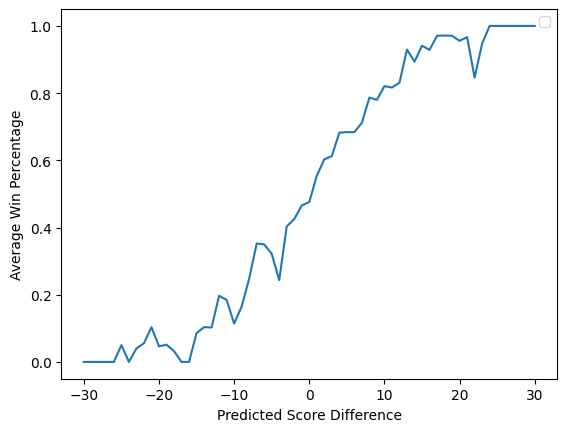

In [164]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.xlabel('Predicted Score Difference')
plt.ylabel('Average Win Percentage')

plt.plot(plot_df.pred_int,plot_df.average_win_pct)
plt.legend()
plt.show()

In [165]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5159024188647106
logloss of cvsplit 1: 0.5140390266958086
logloss of cvsplit 2: 0.5153882831933193
logloss of cvsplit 3: 0.5146568700954653
logloss of cvsplit 4: 0.5146769104804105
logloss of cvsplit 5: 0.5149864839165544
logloss of cvsplit 6: 0.5144124204758508
logloss of cvsplit 7: 0.514563857963726
logloss of cvsplit 8: 0.5160943045912788
logloss of cvsplit 9: 0.5149819799287448


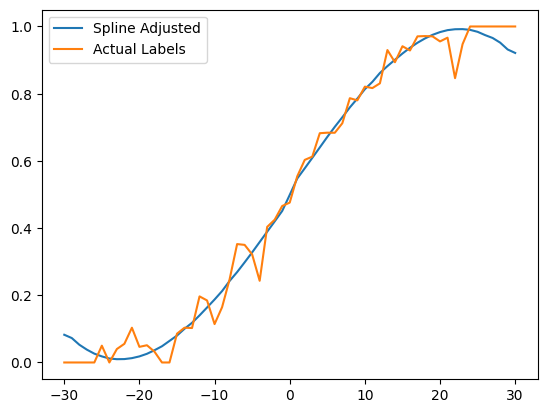

In [166]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline','label']].mean().reset_index()
plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline, label = "Spline Adjusted")
plt.plot(plot_df.pred_int,plot_df.label, label = "Actual Labels")
plt.legend()
plt.show()

In [167]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5140060532020723
adjusted logloss of cvsplit 1: 0.512488481471367
adjusted logloss of cvsplit 2: 0.5136126630711183
adjusted logloss of cvsplit 3: 0.512958935404172
adjusted logloss of cvsplit 4: 0.5131837851748582
adjusted logloss of cvsplit 5: 0.5134691107022871
adjusted logloss of cvsplit 6: 0.5134084929684437
adjusted logloss of cvsplit 7: 0.5132231131615633
adjusted logloss of cvsplit 8: 0.5147329696469917
adjusted logloss of cvsplit 9: 0.5138528519175777


In [168]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_team_df.T1_TourneySeed==1) & (tourney_team_df.T2_TourneySeed==16)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==2) & (tourney_team_df.T2_TourneySeed==15)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==3) & (tourney_team_df.T2_TourneySeed==14)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==4) & (tourney_team_df.T2_TourneySeed==13)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==16) & (tourney_team_df.T2_TourneySeed==1)] = 0.0
    spline_fit[(tourney_team_df.T1_TourneySeed==15) & (tourney_team_df.T2_TourneySeed==2)] = 0.0
    spline_fit[(tourney_team_df.T1_TourneySeed==14) & (tourney_team_df.T2_TourneySeed==3)] = 0.0
    spline_fit[(tourney_team_df.T1_TourneySeed==13) & (tourney_team_df.T2_TourneySeed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.0738978566161343
adjusted logloss of cvsplit 1: 1.0718736991112874
adjusted logloss of cvsplit 2: 1.0732107760876577
adjusted logloss of cvsplit 3: 1.0724529738210122
adjusted logloss of cvsplit 4: 1.0730184479366291
adjusted logloss of cvsplit 5: 1.0727700534655156
adjusted logloss of cvsplit 6: 1.0727384388440937
adjusted logloss of cvsplit 7: 1.0722170963104416
adjusted logloss of cvsplit 8: 1.0733336149062593
adjusted logloss of cvsplit 9: 1.073237109493723


In [169]:
#looking for upsets
pd.concat(
    [tourney_team_df[(tourney_team_df.T1_TourneySeed==1) & (tourney_team_df.T2_TourneySeed==16) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)],
     tourney_team_df[(tourney_team_df.T1_TourneySeed==2) & (tourney_team_df.T2_TourneySeed==15) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)],
     tourney_team_df[(tourney_team_df.T1_TourneySeed==3) & (tourney_team_df.T2_TourneySeed==14) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)],
     tourney_team_df[(tourney_team_df.T1_TourneySeed==4) & (tourney_team_df.T2_TourneySeed==13) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)],
     tourney_team_df[(tourney_team_df.T1_TourneySeed==16) & (tourney_team_df.T2_TourneySeed==1) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)],
     tourney_team_df[(tourney_team_df.T1_TourneySeed==15) & (tourney_team_df.T2_TourneySeed==2) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)],
     tourney_team_df[(tourney_team_df.T1_TourneySeed==14) & (tourney_team_df.T2_TourneySeed==3) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)],
     tourney_team_df[(tourney_team_df.T1_TourneySeed==13) & (tourney_team_df.T2_TourneySeed==4) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)]]
)

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,Sex,T1_AvgScoreDiff,T1_Possessions,T1_Opponent_Possessions,T1_Pts_p100,T1_Opponent_Pts_p100,T1_Ast_p100,T1_Opponent_Ast_p100,T1_Reb_p100,T1_Opponent_Reb_p100,T1_TO_p100,T1_Opponent_TO_p100,T1_Stl_p100,T1_Opponent_Stl_p100,T1_Blk_p100,T1_Opponent_Blk_p100,T1_PF_p100,T1_Opponent_PF_p100,T1_Net_Rating_p100,T1_TS_Pct,T1_Opponent_TS_Pct,T1_eFG_Pct,T1_Opponent_eFG_Pct,T1_Reb_Pct,T1_Off_Reb_Pct,T1_Def_Reb_Pct,T1_AST_TO_Ratio,T1_Opponent_AST_TO_Ratio,T2_AvgScoreDiff,T2_Possessions,T2_Opponent_Possessions,T2_Pts_p100,T2_Opponent_Pts_p100,T2_Ast_p100,T2_Opponent_Ast_p100,T2_Reb_p100,T2_Opponent_Reb_p100,T2_TO_p100,T2_Opponent_TO_p100,T2_Stl_p100,T2_Opponent_Stl_p100,T2_Blk_p100,T2_Opponent_Blk_p100,T2_PF_p100,T2_Opponent_PF_p100,T2_Net_Rating_p100,T2_TS_Pct,T2_Opponent_TS_Pct,T2_eFG_Pct,T2_Opponent_eFG_Pct,T2_Reb_Pct,T2_Off_Reb_Pct,T2_Def_Reb_Pct,T2_AST_TO_Ratio,T2_Opponent_AST_TO_Ratio,T1_win_ratio_14d,T2_win_ratio_14d,T1_Quality,T2_Quality,T1_TourneySeed,T2_TourneySeed,TourneySeedDiff
2029,2018,137,1438,54,1420,74,M,14.151515,1988.92,1988.52,112.070873,88.608613,22.776180,14.684288,54.200269,50.791543,14.228828,21.121236,11.262394,6.436948,6.184261,4.375113,23.329244,24.993462,23.462259,0.562050,0.477372,0.529362,0.436556,0.516284,0.274257,0.743043,1.600707,0.695238,1.516129,2112.80,2130.80,106.351761,103.247607,21.819387,19.757837,49.981068,53.923409,17.133661,20.837244,10.838697,9.104562,3.739114,4.082974,24.233245,27.313685,3.104154,0.547568,0.551434,0.522351,0.520798,0.478912,0.263573,0.710254,1.273481,0.948198,1.000000,1.000000,1.240308e+15,-2.967707e+16,1,16,-15
2543,2023,137,1345,58,1192,63,M,10.352941,2170.44,2222.76,114.492914,95.961777,24.280791,18.940416,56.762684,37.475931,16.310057,13.901636,7.509998,9.177779,5.667054,4.498911,21.470301,28.838021,18.531137,0.566979,0.500996,0.521508,0.472477,0.596610,0.377644,0.799440,1.488701,1.362460,0.312500,2254.00,2240.16,108.296362,108.519034,20.319432,21.471681,43.300799,43.970074,15.838509,20.266410,10.559006,7.990501,2.661934,5.535319,27.151730,22.676952,-0.222672,0.551514,0.598132,0.514713,0.558173,0.497705,0.299526,0.728477,1.282913,1.059471,1.000000,0.666667,-7.379854e+14,-1.790622e+16,1,16,-15
1211,2012,137,1181,70,1250,75,M,9.060606,2236.04,2256.80,114.398669,100.097483,18.380709,16.306274,53.979356,49.849344,17.978211,18.876285,9.212715,8.286069,5.948015,3.899326,26.833151,30.397022,14.301186,0.574305,0.509518,0.529887,0.470936,0.517581,0.347173,0.678333,1.022388,0.863850,10.218750,2176.04,2181.48,111.211191,95.944038,19.117296,19.161303,52.296833,49.691035,16.957409,21.545006,11.488759,8.342960,4.273818,5.638374,26.148416,27.504263,15.267153,0.561735,0.513373,0.509459,0.471035,0.512151,0.314312,0.707513,1.127371,0.889362,0.500000,1.000000,3.468570e+14,-4.385355e+15,2,15,-13
1217,2012,137,1281,84,1313,86,M,14.558824,2241.72,2248.04,121.781489,99.419939,24.579341,19.394673,48.846421,47.685984,15.613011,21.796765,12.445801,7.962492,4.282426,4.003487,21.412130,28.335795,22.361550,0.619407,0.526120,0.577778,0.497101,0.505307,0.306483,0.681462,1.574286,0.889796,2.812500,2187.40,2191.84,101.764652,97.452369,17.555088,16.196438,52.848130,50.368640,21.669562,19.937587,9.554723,9.626615,6.948889,4.562377,27.932705,29.381707,4.312283,0.537318,0.497244,0.497121,0.453954,0.511504,0.334892,0.670025,0.810127,0.812357,1.000000,1.000000,1.574637e+14,-1.100182e+15,2,15,-13
1336,2013,137,1207,68,1195,78,M,8.838710,1924.76,1942.72,104.012968,88.947455,23.847129,17.398287,53.045575,50.650634,20.418130,22.700132,12.157360,10.140422,6.182589,5.250371,27.172219,29.237358,15.065513,0.550678,0.470404,0.514395,0.428125,0.509227,0.305882,0.686916,1.167939,0.766440,5.031250,2213.96,2222.20,104.563768,96.930969,19.828723,19.125191,52.665811,51.210512,21.183761,22.545225,12.737357,9.990100,5.465320,4.365044,25.429547,25.560256,7.632799,0.546259,0.511590,0.513587,0.470908,0.506076,0.331560,0.673469,0.936034,0.848303,0.500000,1.000000,8.846011e+14,5.102

In [170]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_team_df.T1_TourneySeed==1) & (tourney_team_df.T2_TourneySeed==16) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==2) & (tourney_team_df.T2_TourneySeed==15) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==3) & (tourney_team_df.T2_TourneySeed==14) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==4) & (tourney_team_df.T2_TourneySeed==13) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==16) & (tourney_team_df.T2_TourneySeed==1) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)] = 0.0
    spline_fit[(tourney_team_df.T1_TourneySeed==15) & (tourney_team_df.T2_TourneySeed==2) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)] = 0.0
    spline_fit[(tourney_team_df.T1_TourneySeed==14) & (tourney_team_df.T2_TourneySeed==3) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)] = 0.0
    spline_fit[(tourney_team_df.T1_TourneySeed==13) & (tourney_team_df.T2_TourneySeed==4) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.49052804440583314
adjusted logloss of cvsplit 1: 0.4888017748720186
adjusted logloss of cvsplit 2: 0.490133384700662
adjusted logloss of cvsplit 3: 0.48953955014170136
adjusted logloss of cvsplit 4: 0.4897425404294019
adjusted logloss of cvsplit 5: 0.4898739361597997
adjusted logloss of cvsplit 6: 0.4896041198585534
adjusted logloss of cvsplit 7: 0.48929360058302557
adjusted logloss of cvsplit 8: 0.4906839986964519
adjusted logloss of cvsplit 9: 0.49011634563309964


In [171]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_team_df.T1_TourneySeed==1) & (tourney_team_df.T2_TourneySeed==16) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==2) & (tourney_team_df.T2_TourneySeed==15) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==3) & (tourney_team_df.T2_TourneySeed==14) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==4) & (tourney_team_df.T2_TourneySeed==13) & (tourney_team_df.T1_Score > tourney_team_df.T2_Score)] = 1.0
    spline_fit[(tourney_team_df.T1_TourneySeed==16) & (tourney_team_df.T2_TourneySeed==1) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)] = 0.0
    spline_fit[(tourney_team_df.T1_TourneySeed==15) & (tourney_team_df.T2_TourneySeed==2) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)] = 0.0
    spline_fit[(tourney_team_df.T1_TourneySeed==14) & (tourney_team_df.T2_TourneySeed==3) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)] = 0.0
    spline_fit[(tourney_team_df.T1_TourneySeed==13) & (tourney_team_df.T2_TourneySeed==4) & (tourney_team_df.T1_Score < tourney_team_df.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_team_df.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
 
val_cv = pd.concat(val_cv)
print("\n")
print(val_cv.groupby('season')[["y", "pred"]].apply(lambda x: log_loss(x.y, x.pred)))
print("\nAverage Log Loss:", val_cv.groupby('season')[["y", "pred"]].apply(lambda x: log_loss(x.y, x.pred)).mean())

adjusted logloss of cvsplit 0: 0.49052804440583314
adjusted logloss of cvsplit 1: 0.4888017748720186
adjusted logloss of cvsplit 2: 0.490133384700662
adjusted logloss of cvsplit 3: 0.48953955014170136
adjusted logloss of cvsplit 4: 0.4897425404294019
adjusted logloss of cvsplit 5: 0.4898739361597997
adjusted logloss of cvsplit 6: 0.4896041198585534
adjusted logloss of cvsplit 7: 0.48929360058302557
adjusted logloss of cvsplit 8: 0.4906839986964519
adjusted logloss of cvsplit 9: 0.49011634563309964


season
2003    0.501499
2004    0.486793
2005    0.483556
2006    0.539332
2007    0.426594
2008    0.454153
2009    0.471949
2010    0.463213
2011    0.487039
2012    0.473252
2013    0.503541
2014    0.492278
2015    0.426625
2016    0.540468
2017    0.473566
2018    0.543239
2019    0.432572
2021    0.530377
2022    0.528022
2023    0.536068
2024    0.457453
dtype: float64

Average Log Loss: 0.4881709658500985


## Submission

In [172]:
submission_stage2_df = pd.read_csv(data_path + "SampleSubmissionStage2.csv")
submission_stage2_df.head()

,ID,Pred
0,2025_1101_1102,0.5
1,2025_1101_1103,0.5
2,2025_1101_1104,0.5
3,2025_1101_1105,0.5
4,2025_1101_1106,0.5


In [173]:
submission_stage2_df['Season'] = submission_stage2_df['ID'].apply(lambda x: int(x.split('_')[0]))
submission_stage2_df["T1_TeamID"] = submission_stage2_df['ID'].apply(lambda x: int(x.split('_')[1]))
submission_stage2_df["T2_TeamID"] = submission_stage2_df['ID'].apply(lambda x: int(x.split('_')[2]))
submission_stage2_df.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2025_1101_1102,0.5,2025,1101,1102
1,2025_1101_1103,0.5,2025,1101,1103
2,2025_1101_1104,0.5,2025,1101,1104
3,2025_1101_1105,0.5,2025,1101,1105
4,2025_1101_1106,0.5,2025,1101,1106


In [174]:
merge_info = [
    (agg_t1_stats, ['Season', 'T1_TeamID']),
    (agg_t2_stats, ['Season', 'T2_TeamID', 'Sex']),
    (glm_quality_t1, ['Season', 'T1_TeamID']),
    (glm_quality_t2, ['Season', 'T2_TeamID']),
    (seeds_t1, ['Season', 'T1_TeamID', 'Sex']),
    (seeds_t2, ['Season', 'T2_TeamID', 'Sex']),
    (last14_t1, ['Season', 'T1_TeamID', 'Sex']),
    (last14_t2, ['Season', 'T2_TeamID', 'Sex'])
]

for df, keys in merge_info:
    submission_stage2_df = pd.merge(submission_stage2_df, df, on=keys, how='left')

submission_stage2_df['TourneySeedDiff'] = submission_stage2_df['T1_TourneySeed'] - submission_stage2_df['T2_TourneySeed']

submission_stage2_df.head()


invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,ID,Pred,Season,T1_TeamID,T2_TeamID,Sex,T1_AvgScoreDiff,T1_Possessions,T1_Opponent_Possessions,T1_Pts_p100,T1_Opponent_Pts_p100,T1_Ast_p100,T1_Opponent_Ast_p100,T1_Reb_p100,T1_Opponent_Reb_p100,T1_TO_p100,T1_Opponent_TO_p100,T1_Stl_p100,T1_Opponent_Stl_p100,T1_Blk_p100,T1_Opponent_Blk_p100,T1_PF_p100,T1_Opponent_PF_p100,T1_Net_Rating_p100,T1_TS_Pct,T1_Opponent_TS_Pct,T1_eFG_Pct,T1_Opponent_eFG_Pct,T1_Reb_Pct,T1_Off_Reb_Pct,T1_Def_Reb_Pct,T1_AST_TO_Ratio,T1_Opponent_AST_TO_Ratio,T2_AvgScoreDiff,T2_Possessions,T2_Opponent_Possessions,T2_Pts_p100,T2_Opponent_Pts_p100,T2_Ast_p100,T2_Opponent_Ast_p100,T2_Reb_p100,T2_Opponent_Reb_p100,T2_TO_p100,T2_Opponent_TO_p100,T2_Stl_p100,T2_Opponent_Stl_p100,T2_Blk_p100,T2_Opponent_Blk_p100,T2_PF_p100,T2_Opponent_PF_p100,T2_Net_Rating_p100,T2_TS_Pct,T2_Opponent_TS_Pct,T2_eFG_Pct,T2_Opponent_eFG_Pct,T2_Reb_Pct,T2_Off_Reb_Pct,T2_Def_Reb_Pct,T2_AST_TO_Ratio,T2_Opponent_AST_TO_Ratio,T1_Quality,T2_Quality,T1_TourneySeed,T2_TourneySeed,T1_win_ratio_14d,T2_win_ratio_14d,TourneySeedDiff
0,2025_1101_1102,0.5,2025,1101,1102,M,-3.448276,2058.64,2035.16,95.159911,101.171407,17.584425,17.39421,39.783546,44.664793,20.013213,22.848326,14.135546,11.252187,4.080364,6.682521,30.214122,25.256,-6.011495,0.516167,0.564369,0.466891,0.514113,0.473958,0.277042,0.690998,0.878641,0.76129,-11.718750,2067.68,2088.12,95.856225,112.876655,20.699528,19.682777,41.592509,48.799877,18.861719,14.845890,8.753772,10.440013,4.401068,4.932667,27.615492,26.722602,-17.020429,0.530605,0.579936,0.500928,0.546359,0.457690,0.198953,0.725108,1.097436,1.325806,NaN,NaN,NaN,NaN,0.333333,0.0,NaN
1,2025_1101_1103,0.5,2025,1101,1103,M,-3.448276,2058.64,2035.16,95.159911,101.171407,17.584425,17.39421,39.783546,44.664793,20.013213,22.848326,14.135546,11.252187,4.080364,6.682521,30.214122,25.256,-6.011495,0.516167,0.564369,0.466891,0.514113,0.473958,0.277042,0.690998,0.878641,0.76129,8.062500,2351.00,2356.28,114.291791,103.086221,24.074862,16.211995,47.426627,41.378784,15.993194,16.296875,10.293492,9.761149,5.061676,3.310303,24.883028,22.832601,11.205570,0.585658,0.538514,0.554337,0.495418,0.533493,0.315529,0.737720,1.505319,0.994792,NaN,NaN,NaN,13.0,0.333333,1.0,NaN
2,2025_1101_1104,0.5,2025,1101,1104,M,-3.448276,2058.64,2035.16,95.159911,101.171407,17.584425,17.39421,39.783546,44.664793,20.013213,22.848326,14.135546,11.252187,4.080364,6.682521,30.214122,25.256,-6.011495,0.516167,0.564369,0.466891,0.514113,0.473958,0.277042,0.690998,0.878641,0.76129,9.696970,2539.32,2572.84,118.417529,104.437120,21.816864,16.246638,51.116047,42.210165,15.752249,12.904028,7.876124,10.027829,5.788951,5.441458,24.731030,26.702010,13.980409,0.601083,0.520365,0.563500,0.478638,0.544463,0.327010,0.732968,1.385000,1.259036,NaN,NaN,NaN,2.0,0.333333,0.5,NaN
3,2025_1101_1105,0.5,2025,1101,1105,M,-3.448276,2058.64,2035.16,95.159911,101.171407,17.584425,17.39421,39.783546,44.664793,20.013213,22.848326,14.135546,11.252187,4.080364,6.682521,30.214122,25.256,-6.011495,0.516167,0.564369,0.466891,0.514113,0.473958,0.277042,0.690998,0.878641,0.76129,-10.586207,2137.36,2103.60,94.041247,110.144514,16.749635,21.154212,42.622675,46.872029,20.492570,19.490397,10.854512,12.502377,5.146536,4.183305,28.914174,26.003042,-16.103267,0.495474,0.586404,0.450980,0.543014,0.480232,0.318490,0.673611,0.817352,1.085366,NaN,NaN,NaN,NaN,0.333333,0.0,NaN
4,2025_1101_1106,0.5,2025,1101,1106,M,-3.448276,2058.64,2035.16,95.159911,101.171407,17.584425,17.39421,39.783546,44.664793,20.013213,22.848326,14.135546,11.252187,4.080364,6.682521,30.214122,25.256,-6.011495,0.516167,0.564369,0.466891,0.514113,0.473958,0.277042,0.690998,0.878641,0.76129,-0.303030,2324.36,2288.00,102.479822,104.545455,16.176496,18.006993,45.216748,51.879371,12.390507,17.395105,10.841694,7.561189,4.087147,4.720280,25.856580,23.251748,-2.065632,0.508028,0.545620,0.470560,0.503203,0.469616,0.258173,0.711005,1.305556,1.035176,NaN,NaN,NaN,16.0,0.333333,1.0,NaN


In [175]:
submission_x = submission_stage2_df[features].values
dtest = xgb.DMatrix(submission_x)

In [176]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [177]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))

submission_stage2_df["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
submission_stage2_df.head()

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,ID,Pred,Season,T1_TeamID,T2_TeamID,Sex,T1_AvgScoreDiff,T1_Possessions,T1_Opponent_Possessions,T1_Pts_p100,T1_Opponent_Pts_p100,T1_Ast_p100,T1_Opponent_Ast_p100,T1_Reb_p100,T1_Opponent_Reb_p100,T1_TO_p100,T1_Opponent_TO_p100,T1_Stl_p100,T1_Opponent_Stl_p100,T1_Blk_p100,T1_Opponent_Blk_p100,T1_PF_p100,T1_Opponent_PF_p100,T1_Net_Rating_p100,T1_TS_Pct,T1_Opponent_TS_Pct,T1_eFG_Pct,T1_Opponent_eFG_Pct,T1_Reb_Pct,T1_Off_Reb_Pct,T1_Def_Reb_Pct,T1_AST_TO_Ratio,T1_Opponent_AST_TO_Ratio,T2_AvgScoreDiff,T2_Possessions,T2_Opponent_Possessions,T2_Pts_p100,T2_Opponent_Pts_p100,T2_Ast_p100,T2_Opponent_Ast_p100,T2_Reb_p100,T2_Opponent_Reb_p100,T2_TO_p100,T2_Opponent_TO_p100,T2_Stl_p100,T2_Opponent_Stl_p100,T2_Blk_p100,T2_Opponent_Blk_p100,T2_PF_p100,T2_Opponent_PF_p100,T2_Net_Rating_p100,T2_TS_Pct,T2_Opponent_TS_Pct,T2_eFG_Pct,T2_Opponent_eFG_Pct,T2_Reb_Pct,T2_Off_Reb_Pct,T2_Def_Reb_Pct,T2_AST_TO_Ratio,T2_Opponent_AST_TO_Ratio,T1_Quality,T2_Quality,T1_TourneySeed,T2_TourneySeed,T1_win_ratio_14d,T2_win_ratio_14d,TourneySeedDiff
0,2025_1101_1102,0.063581,2025,1101,1102,M,-3.448276,2058.64,2035.16,95.159911,101.171407,17.584425,17.39421,39.783546,44.664793,20.013213,22.848326,14.135546,11.252187,4.080364,6.682521,30.214122,25.256,-6.011495,0.516167,0.564369,0.466891,0.514113,0.473958,0.277042,0.690998,0.878641,0.76129,-11.718750,2067.68,2088.12,95.856225,112.876655,20.699528,19.682777,41.592509,48.799877,18.861719,14.845890,8.753772,10.440013,4.401068,4.932667,27.615492,26.722602,-17.020429,0.530605,0.579936,0.500928,0.546359,0.457690,0.198953,0.725108,1.097436,1.325806,NaN,NaN,NaN,NaN,0.333333,0.0,NaN
1,2025_1101_1103,0.028091,2025,1101,1103,M,-3.448276,2058.64,2035.16,95.159911,101.171407,17.584425,17.39421,39.783546,44.664793,20.013213,22.848326,14.135546,11.252187,4.080364,6.682521,30.214122,25.256,-6.011495,0.516167,0.564369,0.466891,0.514113,0.473958,0.277042,0.690998,0.878641,0.76129,8.062500,2351.00,2356.28,114.291791,103.086221,24.074862,16.211995,47.426627,41.378784,15.993194,16.296875,10.293492,9.761149,5.061676,3.310303,24.883028,22.832601,11.205570,0.585658,0.538514,0.554337,0.495418,0.533493,0.315529,0.737720,1.505319,0.994792,NaN,NaN,NaN,13.0,0.333333,1.0,NaN
2,2025_1101_1104,0.025000,2025,1101,1104,M,-3.448276,2058.64,2035.16,95.159911,101.171407,17.584425,17.39421,39.783546,44.664793,20.013213,22.848326,14.135546,11.252187,4.080364,6.682521,30.214122,25.256,-6.011495,0.516167,0.564369,0.466891,0.514113,0.473958,0.277042,0.690998,0.878641,0.76129,9.696970,2539.32,2572.84,118.417529,104.437120,21.816864,16.246638,51.116047,42.210165,15.752249,12.904028,7.876124,10.027829,5.788951,5.441458,24.731030,26.702010,13.980409,0.601083,0.520365,0.563500,0.478638,0.544463,0.327010,0.732968,1.385000,1.259036,NaN,NaN,NaN,2.0,0.333333,0.5,NaN
3,2025_1101_1105,0.102545,2025,1101,1105,M,-3.448276,2058.64,2035.16,95.159911,101.171407,17.584425,17.39421,39.783546,44.664793,20.013213,22.848326,14.135546,11.252187,4.080364,6.682521,30.214122,25.256,-6.011495,0.516167,0.564369,0.466891,0.514113,0.473958,0.277042,0.690998,0.878641,0.76129,-10.586207,2137.36,2103.60,94.041247,110.144514,16.749635,21.154212,42.622675,46.872029,20.492570,19.490397,10.854512,12.502377,5.146536,4.183305,28.914174,26.003042,-16.103267,0.495474,0.586404,0.450980,0.543014,0.480232,0.318490,0.673611,0.817352,1.085366,NaN,NaN,NaN,NaN,0.333333,0.0,NaN
4,2025_1101_1106,0.049019,2025,1101,1106,M,-3.448276,2058.64,2035.16,95.159911,101.171407,17.584425,17.39421,39.783546,44.664793,20.013213,22.848326,14.135546,11.252187,4.080364,6.682521,30.214122,25.256,-6.011495,0.516167,0.564369,0.466891,0.514113,0.473958,0.277042,0.690998,0.878641,0.76129,-0.303030,2324.36,2288.00,102.479822,104.545455,16.176496,18.006993,45.216748,51.879371,12.390507,17.395105,10.841694,7.561189,4.087147,4.720280,25.856580,23.251748,-2.065632,0.508028,0.545620,0.470560,0.503203,0.469616,0.258173,0.711005,1.305556,1.035176,NaN,NaN,NaN,16.0,0.333333,1.0,NaN


In [178]:
submission_stage2_df[['ID','Pred']].to_csv("submission.csv", index = False)

## Most Important Features

In [220]:
# Get feature importance
importance = sub_models[0].get_score(importance_type="gain")
importance_df = pd.DataFrame(list(importance.items()), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

importance_df.head(15)

,Feature,Importance
58,f58,19669.105469
55,f55,11720.764648
54,f54,11603.952148
27,f27,5551.138184
0,f0,5075.864258
44,f44,4654.134766
17,f17,4573.123047
30,f30,3558.726807
3,f3,3444.319092
4,f4,2893.762939


In [221]:
features

['T1_AvgScoreDiff',
 'T1_Possessions',
 'T1_Opponent_Possessions',
 'T1_Pts_p100',
 'T1_Opponent_Pts_p100',
 'T1_Ast_p100',
 'T1_Opponent_Ast_p100',
 'T1_Reb_p100',
 'T1_Opponent_Reb_p100',
 'T1_TO_p100',
 'T1_Opponent_TO_p100',
 'T1_Stl_p100',
 'T1_Opponent_Stl_p100',
 'T1_Blk_p100',
 'T1_Opponent_Blk_p100',
 'T1_PF_p100',
 'T1_Opponent_PF_p100',
 'T1_Net_Rating_p100',
 'T1_TS_Pct',
 'T1_Opponent_TS_Pct',
 'T1_eFG_Pct',
 'T1_Opponent_eFG_Pct',
 'T1_Reb_Pct',
 'T1_Off_Reb_Pct',
 'T1_Def_Reb_Pct',
 'T1_AST_TO_Ratio',
 'T1_Opponent_AST_TO_Ratio',
 'T2_AvgScoreDiff',
 'T2_Possessions',
 'T2_Opponent_Possessions',
 'T2_Pts_p100',
 'T2_Opponent_Pts_p100',
 'T2_Ast_p100',
 'T2_Opponent_Ast_p100',
 'T2_Reb_p100',
 'T2_Opponent_Reb_p100',
 'T2_TO_p100',
 'T2_Opponent_TO_p100',
 'T2_Stl_p100',
 'T2_Opponent_Stl_p100',
 'T2_Blk_p100',
 'T2_Opponent_Blk_p100',
 'T2_PF_p100',
 'T2_Opponent_PF_p100',
 'T2_Net_Rating_p100',
 'T2_TS_Pct',
 'T2_Opponent_TS_Pct',
 'T2_eFG_Pct',
 'T2_Opponent_eFG_Pct',


In [222]:
# Mapping original feature names to the feature importance DataFrame
feature_mapping = {f"f{i}": features[i] for i in range(len(features))}
importance_df["Feature"] = importance_df["Feature"].map(feature_mapping)

In [223]:
importance_df.head(15)

,Feature,Importance
58,TourneySeedDiff,19669.105469
55,T2_TourneySeed,11720.764648
54,T1_TourneySeed,11603.952148
27,T2_AvgScoreDiff,5551.138184
0,T1_AvgScoreDiff,5075.864258
44,T2_Net_Rating_p100,4654.134766
17,T1_Net_Rating_p100,4573.123047
30,T2_Pts_p100,3558.726807
3,T1_Pts_p100,3444.319092
4,T1_Opponent_Pts_p100,2893.762939


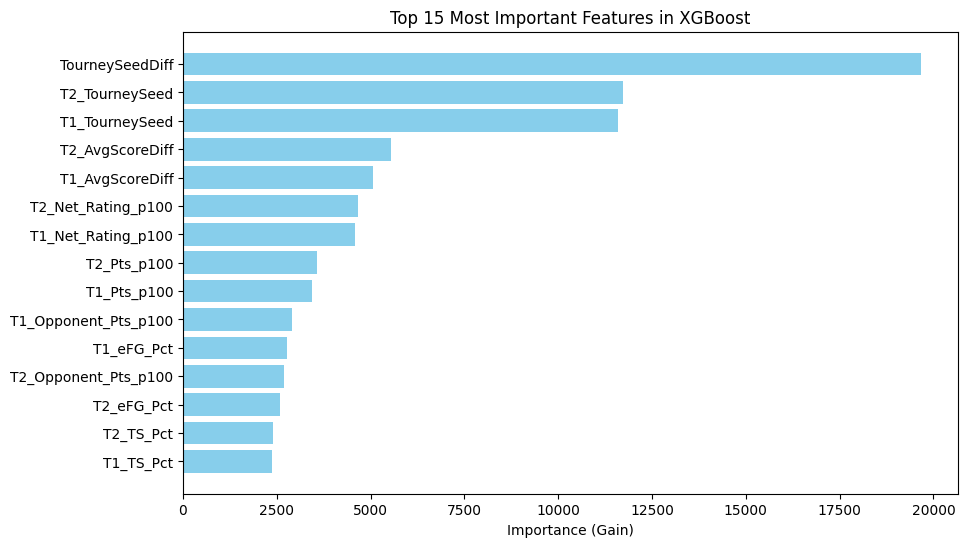

In [236]:
# Select only the top n features
top_n = 15
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.gca().invert_yaxis() # Put in descending order
plt.xlabel("Importance (Gain)")
plt.title(f"Top {top_n} Most Important Features in XGBoost")
plt.show()